In [34]:
import tensorflow as tf
import pennylane as qml
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data = pd.read_csv('replay_data.csv')
features = ['temperature', 'battery', 'wlan.fc.type', 'wlan.duration', 'wlan.seq', 'flight_time', 'time_since_last_packet', 'frame.len', 'wlan.fc.subtype', 'height', 'class']

data = data[features]

# Same data preparation function
def data_prep(data_frame):
    data = data_frame
    shuffled = data.sample(frac=1)  # Shuffle data
    features = shuffled.iloc[:, :-1]  # Select features
    labels = shuffled.iloc[:, -1]  # Select labels
    
    # Convert data to numpy arrays
    features_np = features.to_numpy(dtype=np.float32)
    features_np = scaler.fit_transform(features_np)
    labels_np = labels.to_numpy(dtype=np.int32)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features_np, labels_np, test_size=0.2, random_state=42)
    
    return X_train, y_train, X_test, y_test

def one_hot(labels):  
    depth = 2
    indices = labels.astype(np.int32)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float32) 
    return one_hot_labels

# Data preparation
X_train, Y_train, X_test, Y_test = data_prep(data)
y_train, y_test = one_hot(Y_train), one_hot(Y_test)

# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

keras.backend.set_floatx('float32')

In [35]:
# ===================================================================================
#                     Define Client-Side Model (Classical Layers)
# ===================================================================================
class ClientModel(tf.keras.Model):
    def __init__(self):
        super(ClientModel, self).__init__()
        self.hidden1 = layers.Dense(10, activation="elu")
        self.hidden2 = layers.Dense(10, activation="elu")
        self.out = layers.Dense(5 * 3, activation="elu")  # Output to be sent to the quantum layer

    def call(self, inputs):
        x = self.hidden1(inputs)
        x = self.hidden2(x)
        return self.out(x)

client_model = ClientModel()

In [36]:
 #===================================================================================
#                  Define Server-Side Model (Quantum Layer + Classification)
# ===================================================================================
# Quantum circuit
num_qubits = 5
num_layers = 2
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev, interface="tf", diff_method='backprop')
def quantum_nn(inputs, var):
    for i in range(num_qubits):
        qml.RX(inputs[:, i], wires=i)
        qml.RY(inputs[:, num_qubits + i], wires=i)
        qml.RZ(inputs[:, 2 * num_qubits + i], wires=i)

    for l in range(num_layers):
        v = var[l]
        for i in range(num_qubits):
            qml.RX(v[i], wires=i)
            qml.RY(v[num_qubits + i], wires=i)
            qml.RZ(v[2 * num_qubits + i], wires=i)

        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[num_qubits - 1, 0])

    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

In [37]:
# Server-side model that runs the quantum part and final classification
class ServerModel(tf.keras.Model):
    def __init__(self):
        super(ServerModel, self).__init__()
        self.clayer_out = layers.Dense(2, activation='softmax')  # Final classification layer
        self.weight_shapes = {"var": (num_layers, num_qubits * 3)}
        self.qlayer = qml.qnn.KerasLayer(quantum_nn, self.weight_shapes, output_dim=num_qubits)

    def call(self, inputs):
        x = self.qlayer(inputs)
        return self.clayer_out(x)

server_model = ServerModel()


In [38]:
client_optimizer = keras.optimizers.Adam(learning_rate=0.001)
server_optimizer = keras.optimizers.Adam(learning_rate=0.01)


def split_learning_train_step(x, y):
    # Client-side forward pass
    with tf.GradientTape() as tape_client:
        client_output = client_model(x)

    # Communication: client_output sent to server

    # Server-side forward pass and loss computation
    with tf.GradientTape(persistent=True) as tape_server:
        tape_server.watch(client_output)  # Watch the input from the client
        server_output = server_model(client_output)
        loss = tf.reduce_mean(keras.losses.categorical_crossentropy(y, server_output))

    # Server-side backward pass
    # Compute gradients w.r.t. server parameters
    server_gradients = tape_server.gradient(loss, server_model.trainable_variables)
    server_optimizer.apply_gradients(zip(server_gradients, server_model.trainable_variables))

    # Compute gradient w.r.t. server's input (client_output)
    grad_client_output = tape_server.gradient(loss, client_output)
    del tape_server  # Delete the persistent tape

    # Communication: grad_client_output sent back to client

    # Client-side backward pass
    client_gradients = tape_client.gradient(
        client_output, client_model.trainable_variables, output_gradients=grad_client_output)
    client_optimizer.apply_gradients(zip(client_gradients, client_model.trainable_variables))

    return loss, server_output




# Training loop with optimizer
epochs = 100
batch_size = 256
subset_size = 10000
train_losses = []
train_accuracies = []

# Subset of the data
X_train = X_train[:subset_size]
y_train = y_train[:subset_size]
X_test = X_test[:subset_size]
y_test = y_test[:subset_size]

Epoch 1/100, Loss: 0.7316241172643808, Accuracy: 65.18666666666667%
Epoch 2/100, Loss: 0.5369897545912327, Accuracy: 80.25333333333333%
Epoch 3/100, Loss: 0.4830988530929272, Accuracy: 79.70666666666666%
Epoch 4/100, Loss: 0.46760720855150467, Accuracy: 79.70666666666666%
Epoch 5/100, Loss: 0.4543272608365768, Accuracy: 79.64%
Epoch 6/100, Loss: 0.4411683678627014, Accuracy: 79.88%
Epoch 7/100, Loss: 0.4278958103595636, Accuracy: 80.05333333333333%
Epoch 8/100, Loss: 0.4139484388706012, Accuracy: 80.73333333333333%
Epoch 9/100, Loss: 0.39912239557657486, Accuracy: 81.26666666666667%
Epoch 10/100, Loss: 0.38434300972865176, Accuracy: 81.76%
Epoch 11/100, Loss: 0.3707079268418826, Accuracy: 81.56%
Epoch 12/100, Loss: 0.35819865190065825, Accuracy: 81.65333333333334%
Epoch 13/100, Loss: 0.34607608425311553, Accuracy: 81.8%
Epoch 14/100, Loss: 0.3339608632601224, Accuracy: 82.28%
Epoch 15/100, Loss: 0.3218814230118042, Accuracy: 82.86666666666666%
Epoch 16/100, Loss: 0.31016366604046947, A

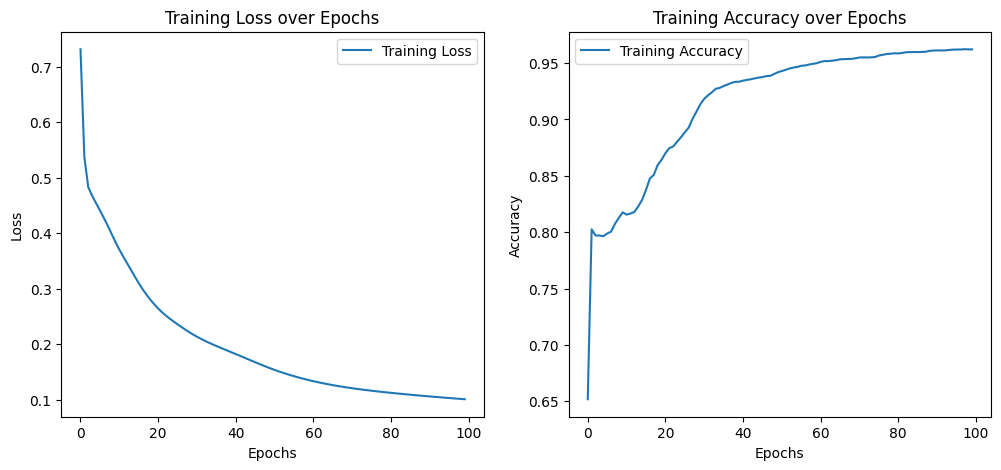

In [39]:
# Training loop
import warnings
import matplotlib.pyplot as plt
# Suppress TensorFlow warnings and any warnings related to casting
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')
tf.get_logger().setLevel('ERROR')
# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for i in range(0, len(X_train), batch_size):
        x_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        # Perform the training step and get the loss and server_output
        loss, server_output = split_learning_train_step(x_batch, y_batch)

        # Sum the loss for the current epoch
        epoch_loss += loss.numpy()

        # Calculate the number of correct predictions
        correct_predictions += tf.reduce_sum(
            tf.cast(tf.equal(tf.argmax(server_output, axis=1), tf.argmax(y_batch, axis=1)), tf.float32)
        ).numpy()
        
        total_samples += len(x_batch)

# ===================================================================================
#                         Evaluation on Test Data
# ===================================================================================
# Calculate average loss and accuracy for the epoch
    avg_epoch_loss = epoch_loss / (len(X_train) // batch_size)
    avg_epoch_accuracy = correct_predictions / total_samples

    # Store the metrics for plotting later
    train_losses.append(avg_epoch_loss)
    train_accuracies.append(avg_epoch_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss}, Accuracy: {avg_epoch_accuracy * 100}%")

# ===================================================================================
#                        Plot the Loss and Accuracy after Training
# ===================================================================================
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()